# MovieLens Recommender System

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
ratings = pd.read_csv('train1.csv')
movies = pd.read_csv('movies.csv')
test = pd.read_csv('test.csv')

In [14]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 10000038
Number of unique movieId's: 48213
Number of unique users: 162541
Average number of ratings per user: 61.52
Average number of ratings per movie: 207.41


### What is the distribution of movie ratings?

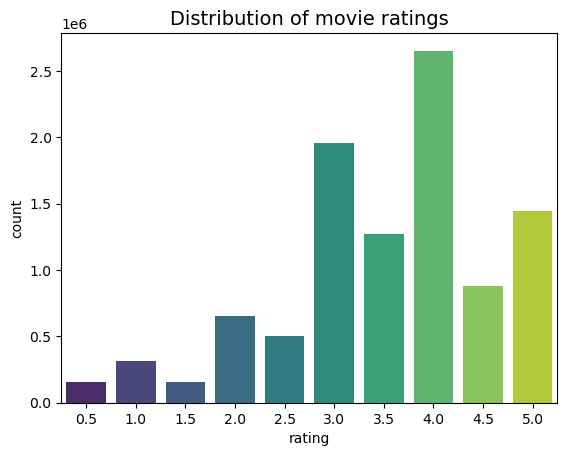

In [15]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [16]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.53.
Mean rating per user: 3.68.


### Which movies are most frequently rated?

In [17]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Shawshank Redemption, The (1994)             32831
Forrest Gump (1994)                          32383
Pulp Fiction (1994)                          31697
Silence of the Lambs, The (1991)             29444
Matrix, The (1999)                           29014
Star Wars: Episode IV - A New Hope (1977)    27560
Jurassic Park (1993)                         25518
Schindler's List (1993)                      24004
Braveheart (1995)                            23722
Fight Club (1999)                            23536
Name: count, dtype: int64

### What are the lowest and highest rated movies? 

In [18]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
5645,5757,History of Kim Skov (Historien om Kim Skov) (1...,Documentary|Drama


In [19]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
3141,3234,Train Ride to Hollywood (1975),Comedy|Fantasy|Musical


In [20]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
3913468,124635,3234,5.0,1047315411


`Lamerica` may be the "highest" rated movie, but it only has 2 ratings. A better approach for evaluating movie popularity is to do look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

In [21]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,23062,3.889971
2,9654,3.263414
3,4727,3.132325
4,968,2.878099
5,4648,3.059165


In [22]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 207.41
Average rating for a given movie: 3.10


Let's test our `bayesian_avg` function out on `Lamerica`:

In [23]:
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)

3.118

`Lamerica`'s average Bayesian rating is 3.5. 

Let's now apply `bayesian_avg` to all movies in our dataset.

In [24]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [25]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
314,318,32831,4.417624,4.409,"Shawshank Redemption, The (1994)"
840,858,20960,4.311355,4.299,"Godfather, The (1972)"
49,50,22032,4.278073,4.267,"Usual Suspects, The (1995)"
1190,1221,13525,4.274085,4.256,"Godfather: Part II, The (1974)"
522,527,24004,4.247625,4.238,Schindler's List (1993)


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `The Usual Suspects` are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

In [26]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
3493,3593,1708,1.576405,1.741,Battlefield Earth (2000)
11310,50798,483,1.467909,1.958,Epic Movie (2007)
6457,6587,307,1.200326,1.966,Gigli (2003)
1688,1760,1036,1.793919,2.012,Spice World (1997)
1501,1556,2127,1.908087,2.014,Speed 2: Cruise Control (1997)


With Bayesian averaging, it looks like `Speed 2: Cruise Control`, `Battlefield Earth`, and `Godzilla` are the worst rated movies. `Gypsy` isn't so bad after all.

### A Glimpse at Movie Genres

In [27]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


**How many movie genres are there?**

In [28]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 25606,
         'Comedy': 16870,
         'Thriller': 8654,
         'Romance': 7719,
         'Action': 7348,
         'Horror': 5989,
         'Documentary': 5605,
         'Crime': 5319,
         '(no genres listed)': 5062,
         'Adventure': 4145,
         'Sci-Fi': 3595,
         'Children': 2935,
         'Animation': 2929,
         'Mystery': 2925,
         'Fantasy': 2731,
         'War': 1874,
         'Western': 1399,
         'Musical': 1054,
         'Film-Noir': 353,
         'IMAX': 195})

In [29]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 25606), ('Comedy', 16870), ('Thriller', 8654), ('Romance', 7719), ('Action', 7348)]


visualize genres popularity with a barplot.

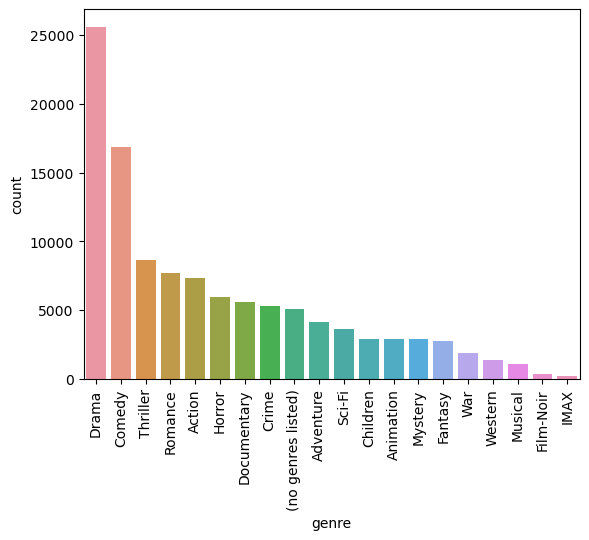

In [30]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

### Data Pre-processing

In [31]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [32]:
X.shape

(162541, 48213)

### Evaluating sparsity

In [33]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.13%


In [34]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

162541

In [35]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 12952 movies.
Least active user rated 1 movies.


In [36]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

48213

In [37]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 32831 ratings.
Least rated movie has 1 ratings.


C:\Users\Geoffrey\AppData\Local\Temp\ipykernel_14604\3364525973.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
C:\Users\Geoffrey\AppData\Local\Temp\ipykernel_14604\3364525973.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True)


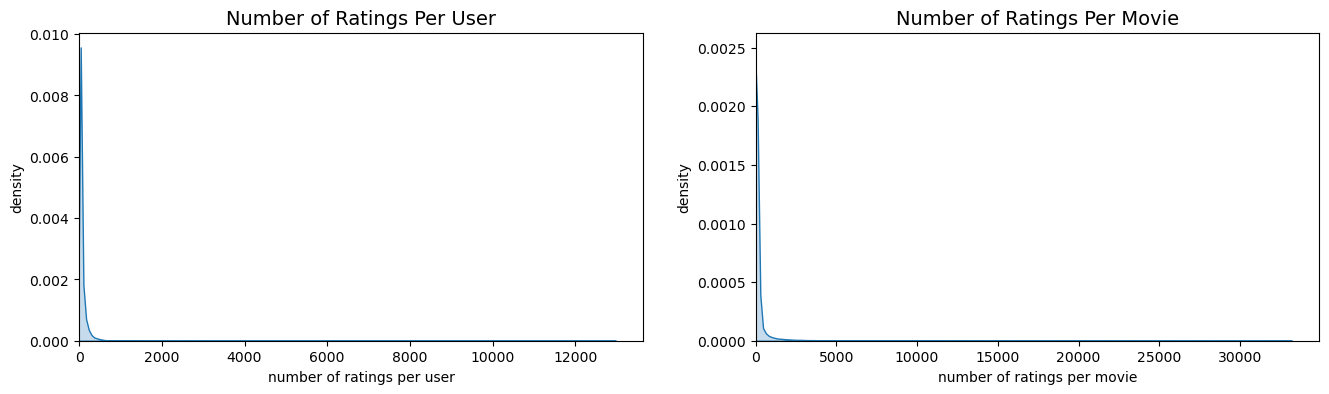

In [38]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

### Step 5: Item-item Recommendations with k-Nearest Neighbors

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$.

In [39]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [40]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[260, 3114, 1270, 356, 588, 480, 1210, 780, 364]

In [41]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Star Wars: Episode IV - A New Hope (1977)
Toy Story 2 (1999)
Back to the Future (1985)
Forrest Gump (1994)
Aladdin (1992)
Jurassic Park (1993)
Star Wars: Episode VI - Return of the Jedi (1983)
Independence Day (a.k.a. ID4) (1996)
Lion King, The (1994)


In [42]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Gigli (2003)
Kicking & Screaming (2005)
Son of the Mask (2005)
Turbo: A Power Rangers Movie (1997)
Piglet's Big Movie (2003)
Planes (2013)
Arthur 2: On the Rocks (1988)
Amityville 3-D (1983)
Splitting Heirs (1993)


### Step 6: Handling the cold-start problem

In [43]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 62423 unique movies in our movies dataset.


In [44]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [45]:
movie_genres.head()

,(no genres listed),Thriller,Comedy,Fantasy,Children,Musical,Animation,War,Western,Film-Noir,Horror,Romance,Action,Adventure,Sci-Fi,Documentary,Crime,IMAX,Drama,Mystery
0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (62423, 62423)


As expected, after passing the `movie_genres` dataframe into the cosine_similarity() function, we get a cosine similarity matrix of shape $(n_{\text{movies}}, n_{\text{movies}})$.

This matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axes.

### Creating a movie finder function

In [50]:
!pip install fuzzywuzzy

  Obtaining dependency information for fuzzywuzzy from https://files.pythonhosted.org/packages/43/ff/74f23998ad2f93b945c0309f825be92e04e0348e062026998b5eefef4c33/fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata


In [51]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

C:\Users\Geoffrey\AppData\Local\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Let's test this out with our Jumanji example. 

In [52]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

In [53]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


Using this handy `movie_idx` dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji.

In [54]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

`similar_movies` is an array of indices that represents Jumanji's top 10 recommendations. We can get the corresponding movie titles by either creating an inverse movie_idx mapper or using iloc on the title column of the movies dataframe.

In [55]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


59                     Indian in the Cupboard, The (1995)
124                     NeverEnding Story III, The (1994)
986                       Escape to Witch Mountain (1975)
1954            Darby O'Gill and the Little People (1959)
2003                                  Return to Oz (1985)
2071                        NeverEnding Story, The (1984)
2072    NeverEnding Story II: The Next Chapter, The (1...
2308                        Santa Claus: The Movie (1985)
4790    Harry Potter and the Sorcerer's Stone (a.k.a. ...
9557                            Magic in the Water (1995)
Name: title, dtype: object

Cool! These recommendations seem pretty relevant and similar to Jumanji. The first 5 movies are family-friendly films from the 90s.

We can test our recommender further with other movie titles. For your convenience, let's package the steps into a single function which takes in the movie title of interest and number of recommendations.

In [56]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [57]:
get_content_based_recommendations('toy story', 5)

Because you watched Toy Story (1995):
2203                                       Antz (1998)
3021                                Toy Story 2 (1999)
3653    Adventures of Rocky and Bullwinkle, The (2000)
3912                  Emperor's New Groove, The (2000)
4780                             Monsters, Inc. (2001)
Name: title, dtype: object


### Step 7: Dimensionality Reduction with Matrix Factorization (advanced)

In [58]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(48213, 20)

In [59]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Willy Wonka & the Chocolate Factory (1971)
Independence Day (a.k.a. ID4) (1996)
Mission: Impossible (1996)
Hunchback of Notre Dame, The (1996)
James and the Giant Peach (1996)
Twister (1996)
Toy Story 2 (1999)
Nutty Professor, The (1996)
Men in Black (a.k.a. MIB) (1997)


In [73]:
# Evaluation and Submission Preparation

from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Predict ratings for the test set
def predict_ratings(user_id, movie_id, X, user_mapper, movie_mapper):
    if user_id in user_mapper and movie_id in movie_mapper:
        user_index = user_mapper[user_id]
        movie_index = movie_mapper[movie_id]
        return X[user_index, movie_index]
    else:
        return np.nan

# Generate predictions
test['predicted_rating'] = test.apply(lambda row: predict_ratings(row['userId'], row['movieId'], X, user_mapper, movie_mapper), axis=1)

# Handle cold-start problem by filling NaNs with global average rating
global_avg_rating = ratings['rating'].mean()
test['predicted_rating'].fillna(global_avg_rating, inplace=True)

# Ensure the predictions are within the valid range
test['predicted_rating'] = test['predicted_rating'].clip(1.0, 5.0)

# Prepare submission file
test['Id'] = test['userId'].astype(str) + '_' + test['movieId'].astype(str)
submission = test[['Id', 'predicted_rating']].rename(columns={'predicted_rating': 'rating'})
submission.to_csv('submissionone.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!


In [63]:
pd.read_csv('submission1.csv')

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0
...,...,...
5000014,162541_4079,1.0
5000015,162541_4467,1.0
5000016,162541_4980,1.0
5000017,162541_5689,1.0


In [74]:
# Predict ratings
test['predicted_rating'] = model.predict(test)

# Ensure predictions are within valid range
test['predicted_rating'] = test['predicted_rating'].clip(1.0, 5.0)

# Calculate and print RMSE
if 'rating' in test.columns:
    actual_ratings = test['rating']
    predicted_ratings = test['predicted_rating']
    print_rmse(actual_ratings, predicted_ratings)


NameError: name 'model' is not defined